Training a neural network to recognise the first five seconds of intro sequence audio from television series Cheers

The dataset used is recorded using the Python sounddevice module. Each sample is the Fourier transform of ~56ms of audio from either 
(1) the first 5 seconds of the Cheers intro,
or
(2) any point in the episode recorded once the intro song is completely finished

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from rlm import lsq_fit
import time

In [2]:
# import data
data_dir = 'cheers/'
# 
# dataset comes in two files: one for the intro recordings and one for the other recordings (body)
# each sample is one line of 1251 integers between 0 and 999
body_fn = data_dir + 'cheers_body_fail.dat'
intro_fn = data_dir + 'cheers_intro_fail.dat'
# normalize
body = pd.read_csv(body_fn).as_matrix()/999
intro = pd.read_csv(intro_fn).as_matrix()/999
body.shape

(10289, 1251)

In [3]:
# adding labels to the data
N_body = body.shape[0]
N_intro = intro.shape[0]

y0 = np.zeros(2*N_body)
for i in range(2*N_body):
    y0[i] = (i+1)%2
y0 = y0.reshape([N_body,2])

y1 = np.zeros(2*N_intro)
for i in range(2*N_intro):
    y1[i] = i%2
y1 = y1.reshape([N_intro,2])

N_examples = N_body + N_intro

body_ = np.concatenate((y0,body),axis=1)
intro_ = np.concatenate((y1,intro),axis=1)
full = np.concatenate((body_,intro_))

# shuffle the full data
np.random.shuffle(full)

# save some samples as an unseen test pool
p_test = .2
pp = int(N_examples*(1-p_test))
train = full[:pp,:]
test = full[pp:,:]
N_train = train.shape[0]

In [4]:
# define neural network (NN) components
# first layer is 2000 relu nodes
# second layer is softmax down to two classes (body/intro)

X = tf.placeholder(tf.float32, [None,1251]) #batch data
Y_ = tf.placeholder(tf.float32, [None,2]) #batch labels
lr = tf.placeholder(tf.float32) #learning rate

W = tf.Variable(tf.truncated_normal([1251,2000], stddev=0.1)) #weights
b = tf.Variable(tf.truncated_normal([2000], stddev=0.1)) #biases

W2 = tf.Variable(tf.truncated_normal([2000,2], stddev=0.1))
b2 = tf.Variable(tf.truncated_normal([2], stddev=0.1))

Y1 = tf.nn.relu(tf.matmul(X,W) + b)
Y2 = tf.nn.softmax(tf.matmul(Y1,W2) + b2)

# cross entropy loss
cross_entropy = -tf.reduce_mean(Y_*tf.log(Y2)) * 10 * 2
correct_prediction = tf.equal(tf.argmax(Y2,1),tf.argmax(Y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_step = tf.train.GradientDescentOptimizer(lr).minimize(cross_entropy)

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [8]:
def step(session,batch_x,batch_y,learning_rate):
    session.run(train_step,feed_dict={X: batch_x, Y_: batch_y,lr: learning_rate})

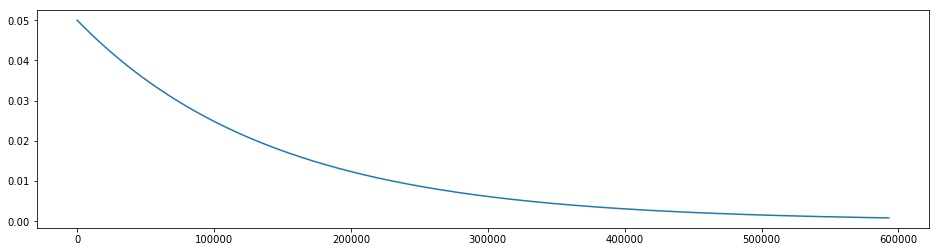

In [9]:
# define learning parameters
%matplotlib inline
batch_size = 20
batches = N_train // batch_size
epochs = 1000
iterations = 1
updates = 1000
N = epochs * batches * iterations

# tracking lists for accuracy and cross entropy loss for both train and test samples
train_acc, test_acc, train_ce, test_ce = [],[],[],[]
it = 0 # iteration counter
its = [] # iteration list

# exponentially decaying learning rate
init_rate,end_rate,decay = (5e-2,5e-5,7e-6)
rate = []
for i in range(N):
    rate.append(end_rate + (init_rate - end_rate)*np.exp(-i*decay))
fig,ax = plt.subplots(figsize=(16,4))
ax.plot(rate)

In [10]:
# train the network
for e in range(epochs):
    np.random.shuffle(train)
    for n in range(batches):
        x = train[n*batch_size:(n+1)*batch_size,2:]
        y = train[n*batch_size:(n+1)*batch_size,:2]
        for _ in range(iterations):
            step(sess,x,y,learning_rate)
            it += 1
            if it % updates == 0:
                train_a,train_c = sess.run([accuracy, cross_entropy],feed_dict = {X:train[:,2:], Y_:train[:,:2]})
                test_a,test_c = sess.run([accuracy, cross_entropy],feed_dict = {X:test[:,2:], Y_:test[:,:2]})
                its.append(it)
                train_acc.append(train_a)
                train_ce.append(train_c)
                test_acc.append(test_a)
                test_ce.append(test_c)
                per = 100*it/N
                sys.stdout.write('\rAccuracy: %.3f %i/%i [%.2f%%]' % (test_a,it,N,per))

Accuracy: 0.964 593000/593000 [100.00%]

In [11]:
# save the model
saver = tf.train.Saver()
seed = str(time.time())[-4:]
dir_ = './models/'
name = dir_ + seed + 'single_bs%i_N%i_batches%i_e_%i_acc(%.3f)'%(batch_size, iterations, batches, epochs, test_a)
saver.save(sess,name)
print(name)

./models/1515single_bs20_N1_batches593_e_1000_acc(0.964)


In [21]:
# plot accuracy and cross entropy loss
fig,(ax1,ax2) = plt.subplots(2,figsize=(16,6))
ax1.plot(its,train_acc,'-r',lw=3)
ax1.plot(its,test_acc,'-b',lw=1)
ax2.plot(its,train_ce,'-r',lw=3)
ax2.plot(its,test_ce,'-b',lw=1)
n = 100
T1 = lsq_fit(its[-n:],test_acc[-n:])
T2 = lsq_fit(its[-n:],test_ce[-n:])
T1

[[0.9567040130686654], [1.3321217494861037e-08]]

In [23]:
# to get a better feel for how the NN is clasifying samples, calculate the rate of false positives/negatives
# this network's role would be to input a command upon detecting the intro (to skip it)
# therefore the flaw that needs to be minimized is the false positive (detecting a body sample as intro sample))

truebody = sess.run(accuracy,feed_dict={X:body,Y_:y0})
trueintro = sess.run(accuracy,feed_dict={X:intro,Y_:y1})
falsebody = 1-truebody
falseintro = 1-trueintro
print(
'''      | Body | Intro |
True  | %.3f | %.3f  |
False | %.3f | %.3f  |''' % (truebody, trueintro, falsebody, falseintro))

      | Body | Intro |
True  | 0.986 | 0.960  |
False | 0.014 | 0.040  |


This simple network is able to reliably recognise the intro to an episode of Cheers has begun. It still has a false positive rate of at least 1.4% which means that by itself the network would end up skipping parts of the actual episode too often (given the audio is sampled at a frequency on the order of ~1s). 

To use this network to reliably identify just the intro to skip without false positives, techniques like thresholding the output required for a sample to be identified as the intro (the NN returns arrays of the form [P1, P2] where P1 is the probability the sample is of class 'body' and P2 is the probablity of class 'intro'. Currently the network just chooses the higher of the two) or requiring consecutive positives to trigger the skip would be necessary for good performance.  

Better accuracy might be attained by a different NN layout, or increasing sampling time (currently 56ms).